### Import and Data Processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white')

def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['cohort_period'] = np.arange(len(df))
    return df

customers = pd.read_csv('customers.csv')
customers = customers.rename(columns={'id': 'customer_id'})

orders = pd.read_csv('orders.csv')
orders.loc[:, 'order_date'] = orders.loc[:, 'order_date'].apply(pd.to_datetime, format='%Y-%m-%d')
orders = orders.merge(customers, on='customer_id').drop(columns='name')
orders['order_month'] = orders.loc[:, 'order_date'].dt.strftime('%Y-%m')
cohorts = orders.groupby('customer_id', as_index=False).agg({'order_month': pd.Series.min})
cohorts = cohorts.rename(columns={'order_month': 'cohort'})
orders = orders.merge(cohorts, how='left', on='customer_id')

cohorts_group = orders.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group = cohorts_group.rename(columns={'customer_id': 'total_users'})
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group = cohorts_group.reset_index()
cohorts_group = cohorts_group.set_index(['cohort', 'cohort_period']) 
cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()

### Анализ

Подготовив данные, мы решаем сначала попытаться узнать общее состояние продукта и строим график объема продаж по месяцам.

Пусть, мы не видим большого прогресса за три прошедших года, но некоторый рост к прошлому году всё-же стоит отметить.

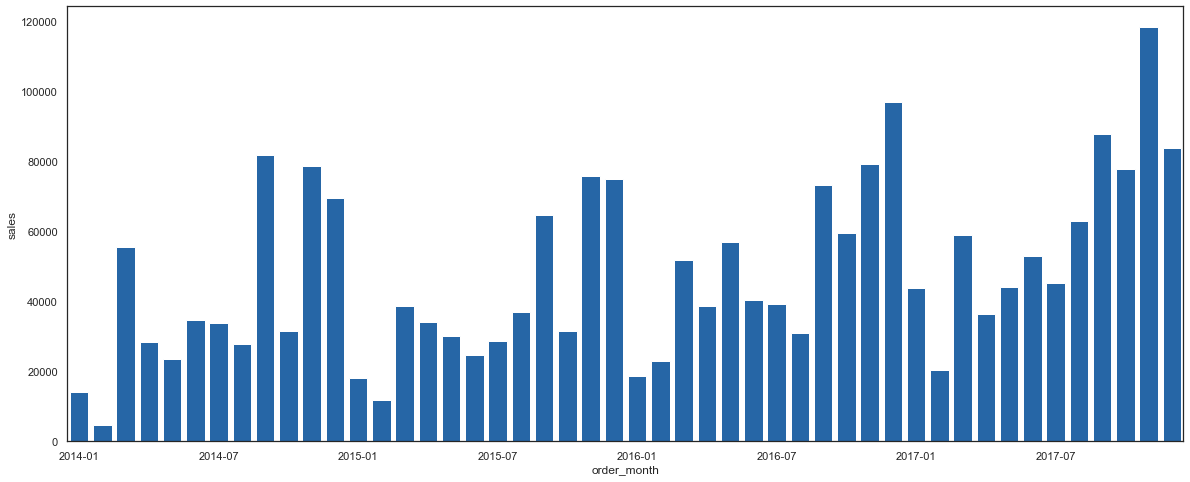

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
sales_by_month = orders.groupby(['order_month'], as_index=False).agg({'sales': pd.Series.sum})
sns.barplot(data=sales_by_month, x='order_month', y='sales', color='#1166BB')
ax.set_xticks(range(0,len(sales_by_month),6))
plt.show()

Далее мы возвращаемся к предложенной гипотезе и решаем оценить отток пользователей через обратную ему метрику - retention.

На графике представлены изменения долей активных пользователей по когортам за последние 2 года. Мы действительно видим, что пользователи интернет-магазина, пришедшие в 2017-м году, активны лишь на самом раннем этапе и достаточно быстро перестают совершать покупки. 

Однако, некоторые особенности распределения retention выглядят подозрительно:
1. Ни одна из когорт не активна в декабре 2017-го года (светло-розовые ячейки), что не согласовывается с построенным ранее растущим графиком продаж.
2. Пустые ряды по горизонтали говорят о том, что в некоторых месяцах в магазин не приходили новые пользователи.

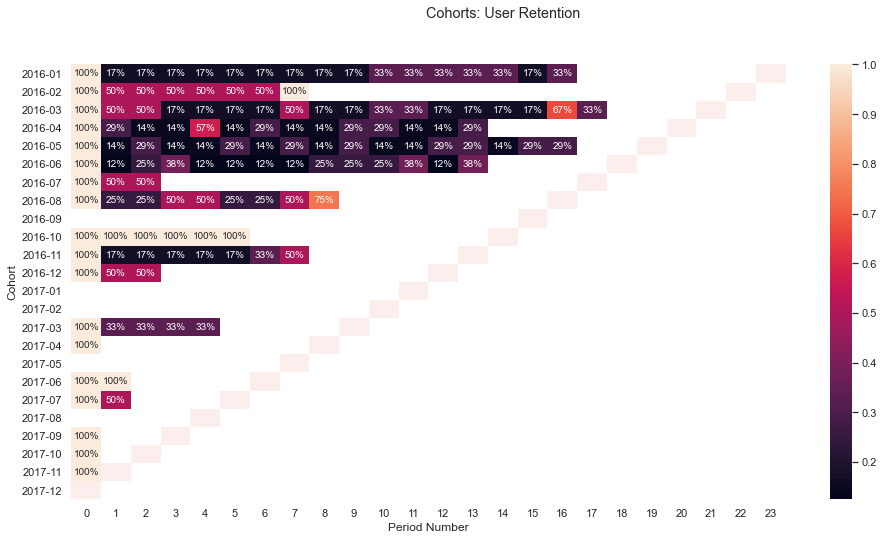

In [5]:
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention = user_retention.reindex(columns=sorted(orders.order_month.unique()), fill_value=np.nan)
user_retention = user_retention.loc[0:23, '2016-01':]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
fig.suptitle('Cohorts: User Retention')
sns.heatmap(np.rot90(np.eye(*user_retention.shape)), mask=np.rot90(np.eye(*user_retention.shape) == 0), annot=False, cbar=False, cmap=sns.color_palette('hls', 3), alpha=0.1);
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', annot_kws={"fontsize": 10})
ax.set_xlabel('Period Number')
ax.set_ylabel('Cohort')
plt.show()

В первую очередь, мы решаем обратиться к более ранним когортам, чтобы найти источник увеличивающихся продаж, и обнаруживаем, что рост продаж в конце 2017-го года связан с возросшей активностью клиентов, привлеченных в магазин в 2014-м году. Неизвестно, какие изменения вносились в работу магазина в прошедшем году, но изменения retention свидетельствуют о том, что когорта 2014-го года воспринимает их позитивно.

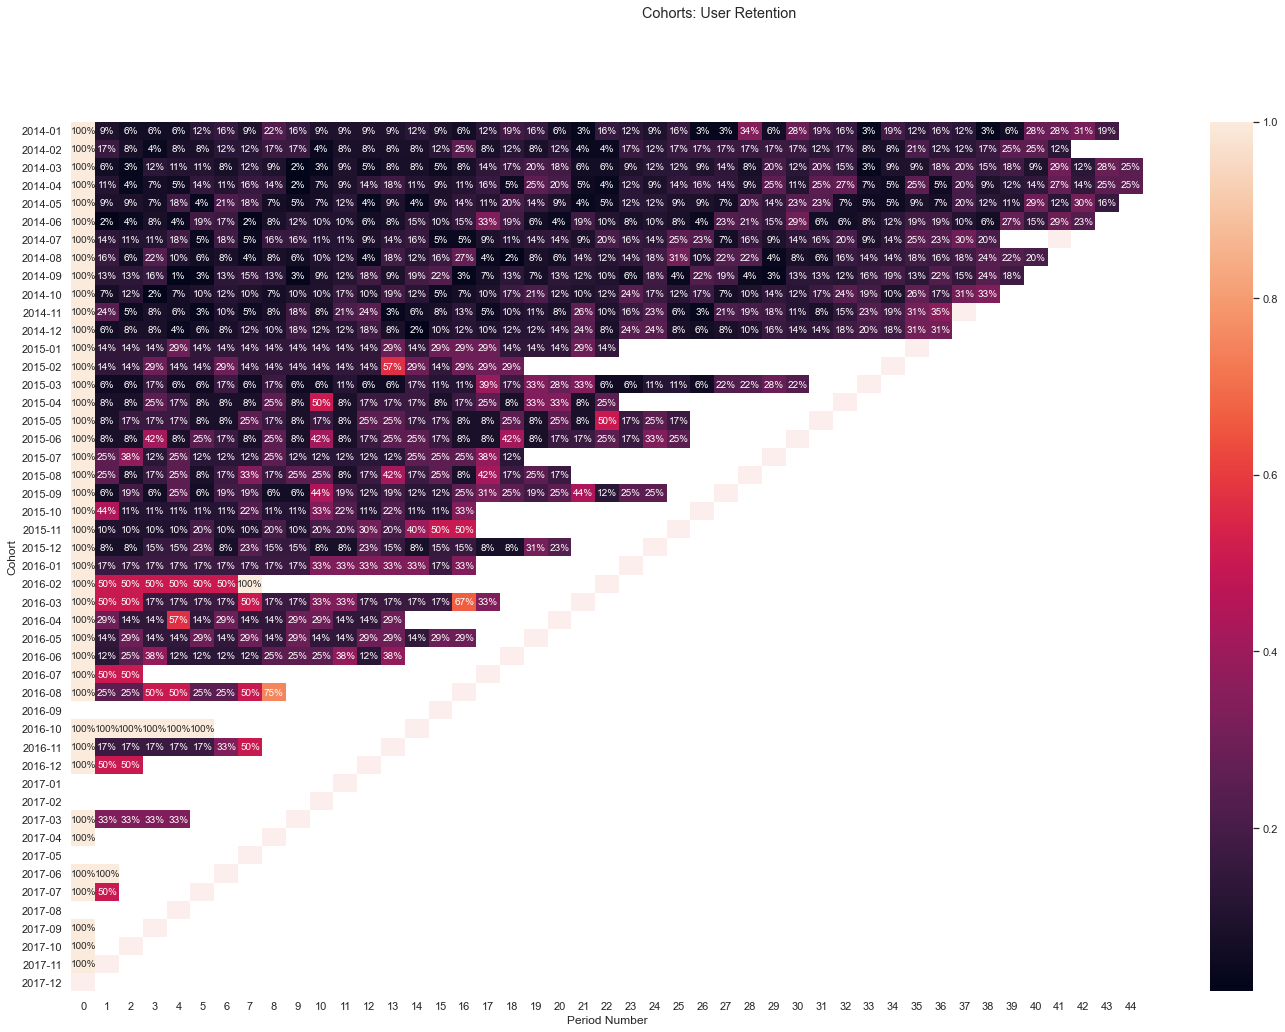

In [6]:
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention = user_retention.reindex(columns=sorted(orders.order_month.unique()), fill_value=np.nan)
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
fig.suptitle('Cohorts: User Retention')
sns.heatmap(np.rot90(np.eye(*user_retention.shape)), mask=np.rot90(np.eye(*user_retention.shape) == 0), annot=False, cbar=False, cmap=sns.color_palette('hls', 3), alpha=0.1)
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', annot_kws={"fontsize": 10})
ax.set_xlabel('Period Number')
ax.set_ylabel('Cohort')
plt.show()

В попытке разобраться с происходящим мы переходим от относительной метрики к абсолютной и строим график количества активных пользователей из каждой когорты по месяцам. Оказывается, количество привлекаемых пользователей настолько мало, что даже их естественный отток сводит активность новых когорт к нулю.

Выводы:
1. Мы не нашли подтверждений увеличивающегося оттока пользователей. Напротив, когорты 2014-го года увеливают свою активность.
2. У нас огромная проблема с привлечением новых пользователей.
3. Транзакции магазина имеют ярко выраженную сезонность с пиком в последние месяцы календарного года.

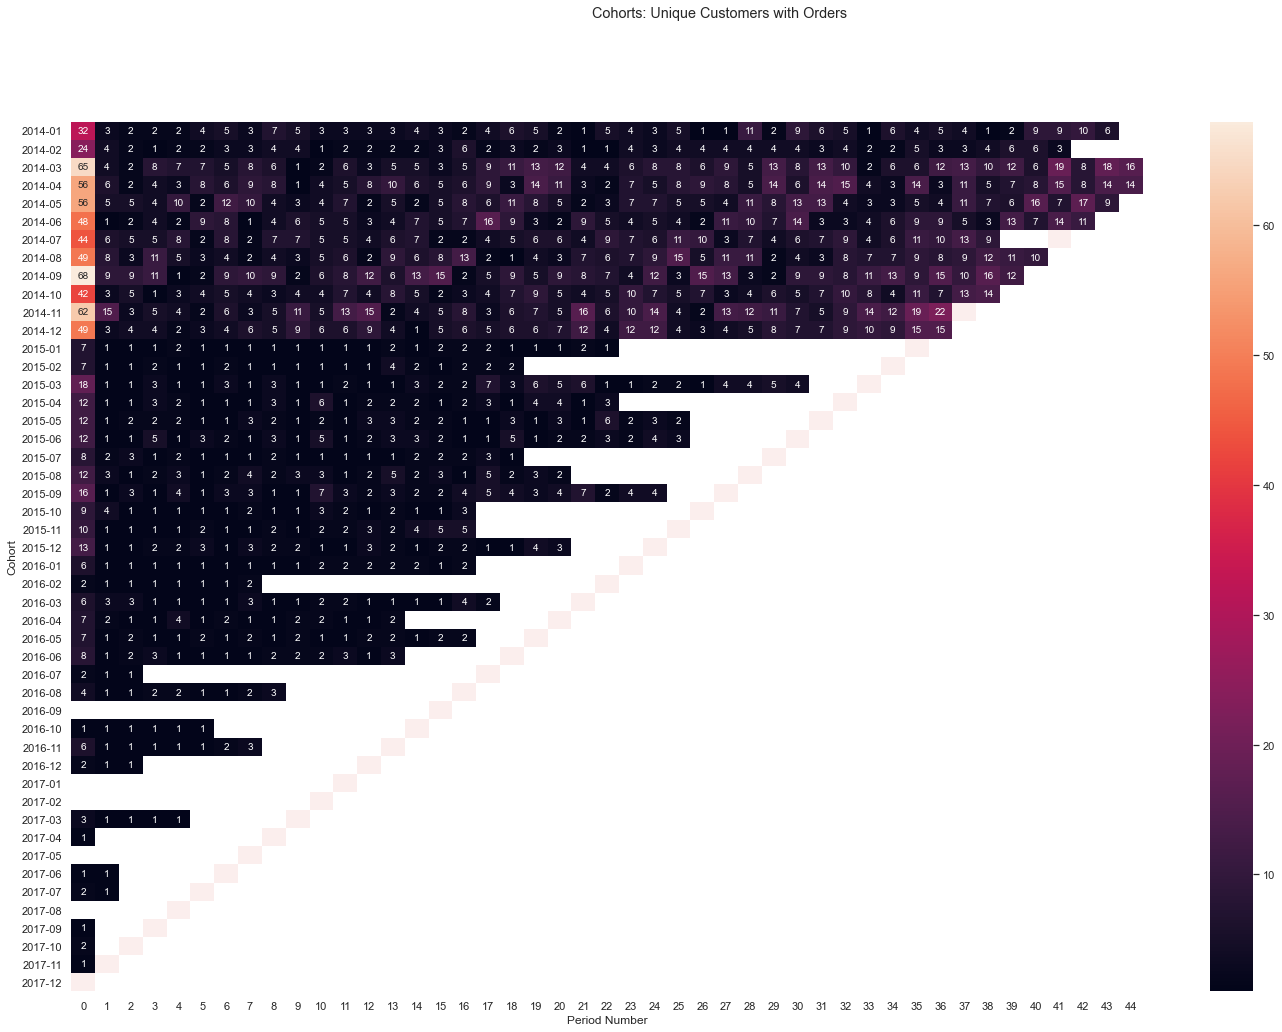

In [5]:
user_retention = cohorts_group['total_users'].unstack(0)#.divide(cohort_group_size, axis=1)
user_retention = user_retention.reindex(columns=sorted(orders.order_month.unique()), fill_value=np.nan)
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
fig.suptitle('Cohorts: Unique Customers with Orders')
sns.heatmap(np.rot90(np.eye(*user_retention.shape)), mask=np.rot90(np.eye(*user_retention.shape) == 0), annot=False, cbar=False, cmap=sns.color_palette('hls', 3), alpha=0.1);
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, annot_kws={"fontsize": 10})
ax.set_xlabel('Period Number')
ax.set_ylabel('Cohort')
plt.show()

### Инструмент

Для отслеживания ситуации мы предлагаем руководителю продукта использовать всё те же тепловые карты для retention и количества уникальных пользователей.

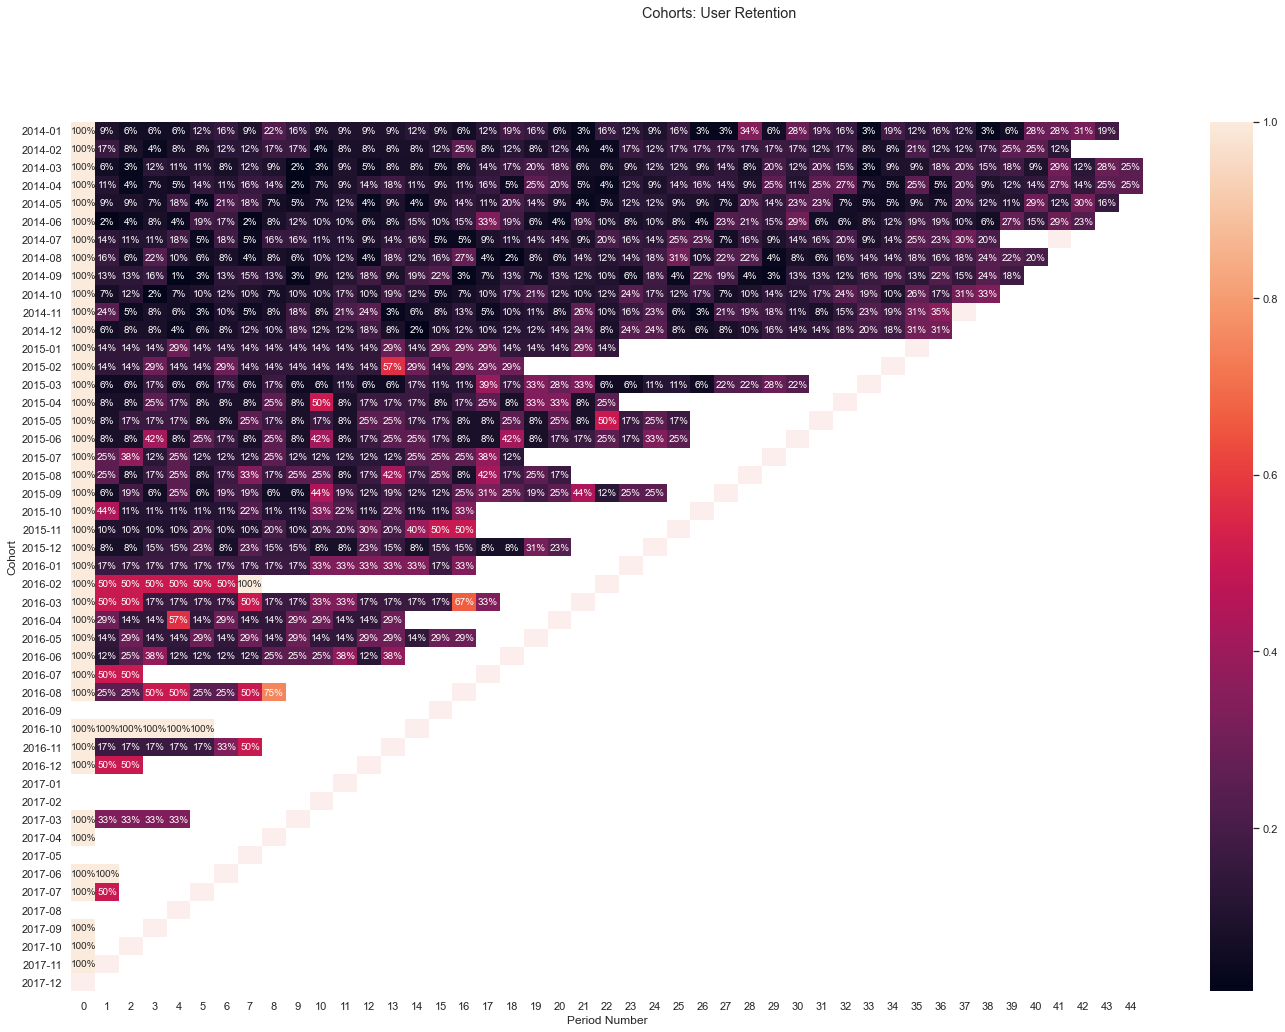

In [7]:
user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention = user_retention.reindex(columns=sorted(orders.order_month.unique()), fill_value=np.nan)
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
fig.suptitle('Cohorts: User Retention')
sns.heatmap(np.rot90(np.eye(*user_retention.shape)), mask=np.rot90(np.eye(*user_retention.shape) == 0), annot=False, cbar=False, cmap=sns.color_palette('hls', 3), alpha=0.1)
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', annot_kws={"fontsize": 10})
ax.set_xlabel('Period Number')
ax.set_ylabel('Cohort')
plt.show()

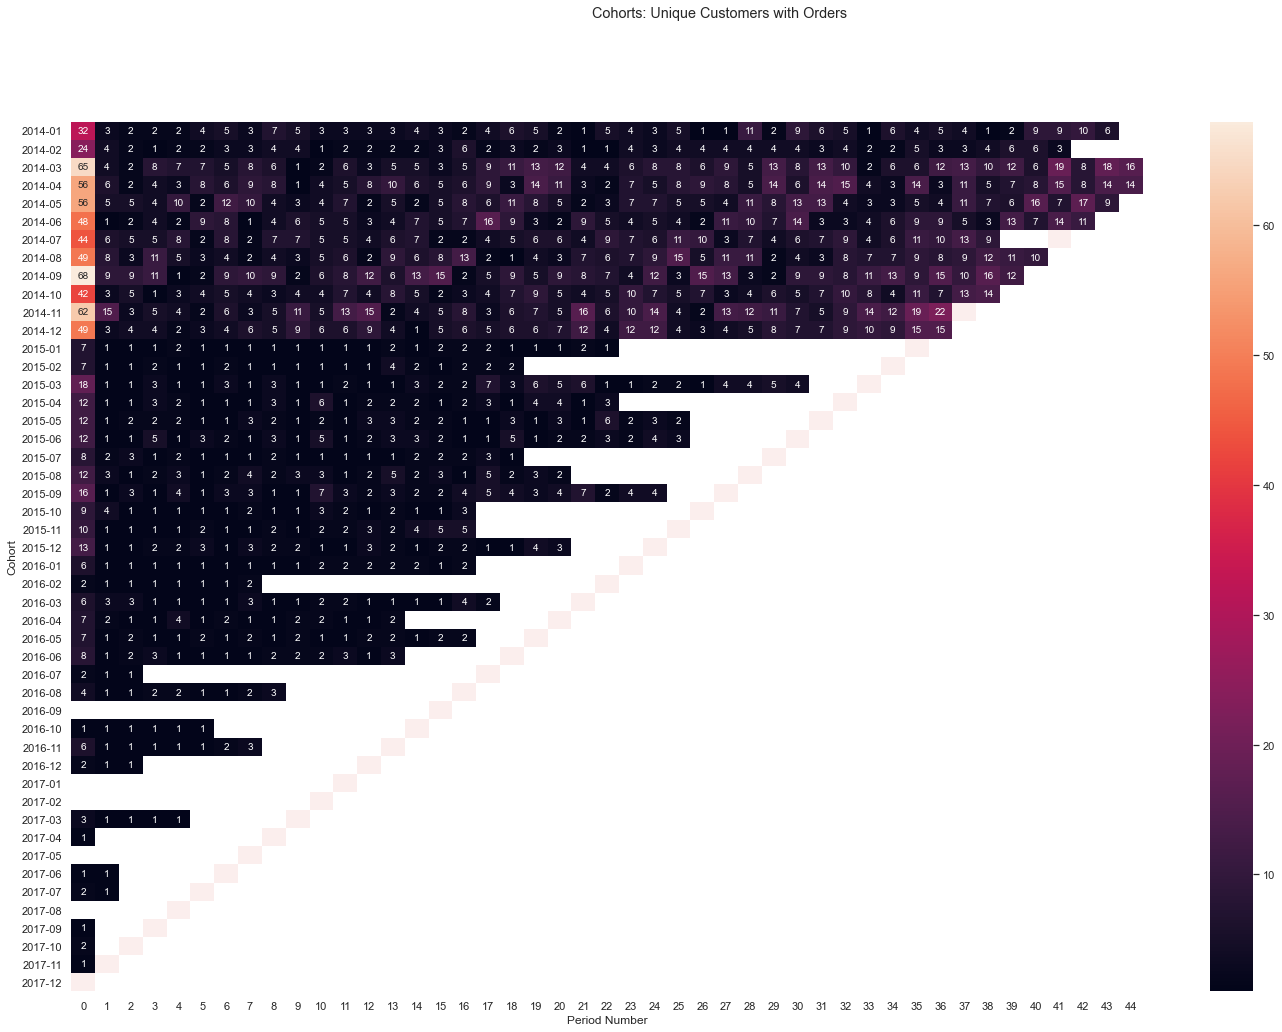

In [8]:
user_retention = cohorts_group['total_users'].unstack(0)#.divide(cohort_group_size, axis=1)
user_retention = user_retention.reindex(columns=sorted(orders.order_month.unique()), fill_value=np.nan)
fig, ax = plt.subplots(1, 1, figsize=(24, 16))
fig.suptitle('Cohorts: Unique Customers with Orders')
sns.heatmap(np.rot90(np.eye(*user_retention.shape)), mask=np.rot90(np.eye(*user_retention.shape) == 0), annot=False, cbar=False, cmap=sns.color_palette('hls', 3), alpha=0.1);
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, annot_kws={"fontsize": 10})
ax.set_xlabel('Period Number')
ax.set_ylabel('Cohort')
plt.show()